## AI-Based Bearing Fault Detection using NASA IMS Dataset

### 📌 Project Overview  
This project focuses on predictive maintenance by detecting early signs of bearing faults using NASA’s IMS vibration dataset. Bearings are critical components in industrial machines — if they fail, the entire system can face costly breakdowns.  

Our goal: Classify each bearing as NORMAL or FAULTY using machine learning, making maintenance smarter and preventing unplanned downtime.


In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\manik\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.stats import kurtosis, skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
def load_and_downsample(folder_path, target_points=2048):
    signals = []
    file_names = sorted(os.listdir(folder_path))

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)

        if not os.path.isfile(file_path):
            continue  

        try:
            if os.path.getsize(file_path) == 0:
                print(f"⚠️ Skipping empty file: {file_name}")
                continue

            data = np.loadtxt(file_path, dtype=float, ndmin=2)

            if data.shape[1] < 4:
                print(f"⚠️ Skipping {file_name} (not enough columns)")
                continue

            data_ds = resample(data[:, :4], target_points, axis=0)
            signals.append(data_ds)

        except Exception as e:
            print(f"⚠️ Could not read {file_name}: {str(e)}")

    return np.array(signals), file_names


In [ ]:
signals_1, files_1 = load_and_downsample(folder_1)
signals_2, files_2 = load_and_downsample(folder_2)
signals_4, files_4 = load_and_downsample(folder_4)
print(f"✅ 1st_test: {signals_1.shape}")
print(f"✅ 2nd_test: {signals_2.shape}")
print(f"✅ 4th_test: {signals_4.shape}")


✅ 1st_test: (2156, 2048, 4)
✅ 2nd_test: (984, 2048, 4)
✅ 4th_test: (6324, 2048, 4)


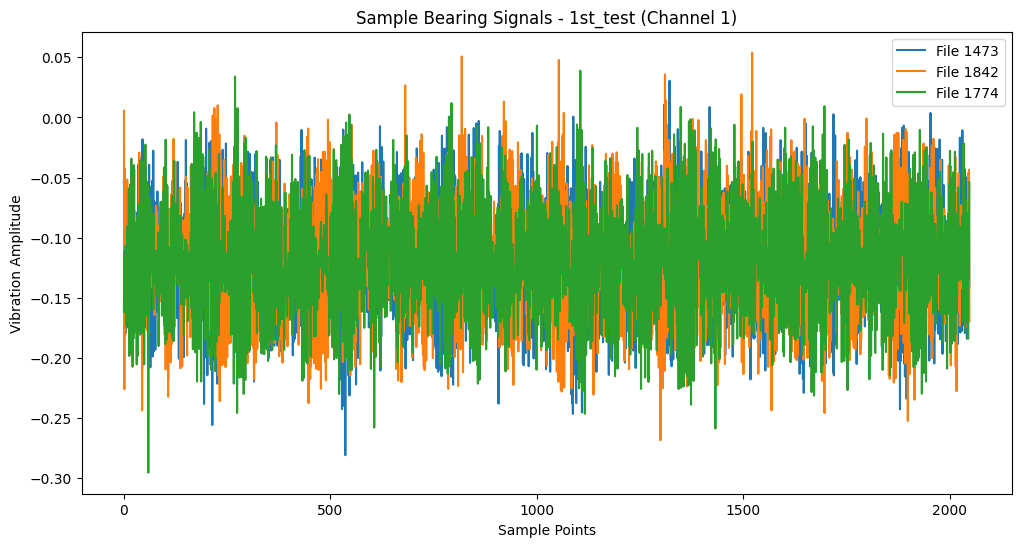

In [ ]:
# Plot 3 random files from 1st_test - Channel 1
import random

plt.figure(figsize=(12,6))

# Pick 3 random indices from 1st_test
samples = random.sample(range(signals_1.shape[0]), 3)

for idx in samples:
    plt.plot(signals_1[idx][:, 0], label=f"File {idx}")

plt.title("Sample Bearing Signals - 1st_test (Channel 1)")
plt.xlabel("Sample Points")
plt.ylabel("Vibration Amplitude")
plt.legend()
plt.show()


In [ ]:
from scipy.stats import kurtosis, skew

def extract_features(signals):
    feature_list = []
    for sig in signals:
        feats = {}
        for ch in range(4):
            channel = sig[:, ch]
            feats[f'ch{ch+1}_rms'] = np.sqrt(np.mean(channel**2))
            feats[f'ch{ch+1}_kurt'] = kurtosis(channel)
            feats[f'ch{ch+1}_skew'] = skew(channel)
            feats[f'ch{ch+1}_p2p'] = np.max(channel) - np.min(channel)
        feature_list.append(feats)
    return pd.DataFrame(feature_list)

print("📊 Extracting features...")

features_1 = extract_features(signals_1)
features_2 = extract_features(signals_2)
features_4 = extract_features(signals_4)

print(" Features for 1st_test:", features_1.shape)
features_1.head()


📊 Extracting features...
✅ Features for 1st_test: (2156, 16)


,ch1_rms,ch1_kurt,ch1_skew,ch1_p2p,ch2_rms,ch2_kurt,ch2_skew,ch2_p2p,ch3_rms,ch3_kurt,ch3_skew,ch3_p2p,ch4_rms,ch4_kurt,ch4_skew,ch4_p2p
0,0.106918,-0.857816,0.057659,0.267287,0.100262,-0.251807,-0.127836,0.267433,0.113668,-0.740449,-0.154948,0.378177,0.107778,-0.533615,0.018196,0.314490
1,0.106640,-0.824910,0.085616,0.270973,0.100112,-0.210089,-0.078431,0.248180,0.115003,-0.584029,-0.136779,0.423569,0.108386,-0.611023,-0.031808,0.318870
2,0.108005,-0.880642,0.074755,0.283391,0.102138,-0.215342,-0.091496,0.236252,0.114999,-0.811902,-0.088054,0.323681,0.110152,-0.540091,0.010472,0.316356
3,0.107451,-0.831761,0.107936,0.254321,0.101692,-0.324269,-0.132378,0.207053,0.114633,-0.789415,-0.112989,0.348700,0.108836,-0.521463,-0.005575,0.292293
4,0.107144,-0.854002,0.049284,0.245189,0.102201,-0.402282,-0.108771,0.236943,0.114396,-0.661009,-0.108126,0.363749,0.108272,-0.481148,-0.012774,0.333108


In [ ]:
def label_data(signals):
    n = len(signals)
    labels = np.array([0 if i < n*0.8 else 1 for i in range(n)])
    return labels

labels_1 = label_data(signals_1)
labels_2 = label_data(signals_2)
labels_4 = label_data(signals_4)

#  Combine everything into one dataset
X = pd.concat([features_1, features_2, features_4], ignore_index=True)
y = np.concatenate([labels_1, labels_2, labels_4])

print(" Final dataset:", X.shape, y.shape)
print("\nCounts of Normal (0) vs Faulty (1):")
print(pd.Series(y).value_counts())


✅ Final dataset: (9464, 16) (9464,)

Counts of Normal (0) vs Faulty (1):
0    7573
1    1891
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#  Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#  Make predictions
y_pred = rf.predict(X_test)


📈 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92      1507
           1       0.85      0.46      0.59       386

    accuracy                           0.87      1893
   macro avg       0.86      0.72      0.76      1893
weighted avg       0.87      0.87      0.86      1893



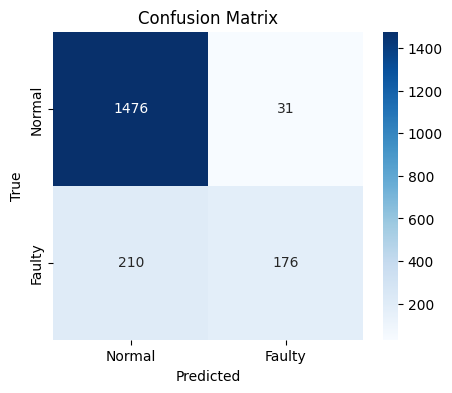

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#  Classification Report
print("📈 Classification Report:")
print(classification_report(y_test, y_pred))

#  Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Faulty'],
            yticklabels=['Normal','Faulty'])
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [ ]:
from scipy.fftpack import fft
def extract_features_with_fft(signals):
    feature_list = []
    for sig in signals:
        feats = {}
        for ch in range(4):
            channel = sig[:, ch]
            feats[f'ch{ch+1}_rms'] = np.sqrt(np.mean(channel**2))
            feats[f'ch{ch+1}_kurt'] = kurtosis(channel)
            feats[f'ch{ch+1}_skew'] = skew(channel)
            feats[f'ch{ch+1}_p2p'] = np.max(channel) - np.min(channel)
            fft_vals = np.abs(fft(channel))
            fft_freqs = np.fft.fftfreq(len(channel))
            fft_vals = fft_vals[:len(fft_vals)//2]
            fft_freqs = fft_freqs[:len(fft_freqs)//2]
            dom_freq = fft_freqs[np.argmax(fft_vals)]
            feats[f'ch{ch+1}_dom_freq'] = dom_freq
            psd = fft_vals**2
            psd_norm = psd / np.sum(psd)
            feats[f'ch{ch+1}_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

        feature_list.append(feats)
    return pd.DataFrame(feature_list)

print("Extracting features with FFT...")

features_1_fft = extract_features_with_fft(signals_1)
features_2_fft = extract_features_with_fft(signals_2)
features_4_fft = extract_features_with_fft(signals_4)

print(" Features with FFT for 1st_test:", features_1_fft.shape)
features_1_fft.head()


📊 Extracting features with FFT...
✅ Features with FFT for 1st_test: (2156, 24)


,ch1_rms,ch1_kurt,ch1_skew,ch1_p2p,ch1_dom_freq,ch1_entropy,ch2_rms,ch2_kurt,ch2_skew,ch2_p2p,...,ch3_skew,ch3_p2p,ch3_dom_freq,ch3_entropy,ch4_rms,ch4_kurt,ch4_skew,ch4_p2p,ch4_dom_freq,ch4_entropy
0,0.106918,-0.857816,0.057659,0.267287,0.0,0.969821,0.100262,-0.251807,-0.127836,0.267433,...,-0.154948,0.378177,0.0,1.438382,0.107778,-0.533615,0.018196,0.314490,0.0,1.200442
1,0.106640,-0.824910,0.085616,0.270973,0.0,0.887656,0.100112,-0.210089,-0.078431,0.248180,...,-0.136779,0.423569,0.0,1.331511,0.108386,-0.611023,-0.031808,0.318870,0.0,1.099639
2,0.108005,-0.880642,0.074755,0.283391,0.0,0.860654,0.102138,-0.215342,-0.091496,0.236252,...,-0.088054,0.323681,0.0,1.258165,0.110152,-0.540091,0.010472,0.316356,0.0,1.081734
3,0.107451,-0.831761,0.107936,0.254321,0.0,0.961373,0.101692,-0.324269,-0.132378,0.207053,...,-0.112989,0.348700,0.0,1.408750,0.108836,-0.521463,-0.005575,0.292293,0.0,1.132320
4,0.107144,-0.854002,0.049284,0.245189,0.0,0.995264,0.102201,-0.402282,-0.108771,0.236943,...,-0.108126,0.363749,0.0,1.389622,0.108272,-0.481148,-0.012774,0.333108,0.0,1.148666


In [ ]:
#  Merge all FFT feature sets
X_fft = pd.concat([features_1_fft, features_2_fft, features_4_fft], ignore_index=True)
y_fft = np.concatenate([labels_1, labels_2, labels_4])
print(" New dataset shape:", X_fft.shape)
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_fft, y_fft, test_size=0.2, random_state=42)
rf_fft = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
rf_fft.fit(X_train_fft, y_train_fft)
y_pred_fft = rf_fft.predict(X_test_fft)


✅ New dataset shape: (9464, 24)


⚖️ Before SMOTE: 6066 normal, 1505 faulty
✅ After SMOTE: 6066 normal, 6066 faulty
📈 Model Performance (with FFT + SMOTE):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1507
           1       0.76      0.64      0.69       386

    accuracy                           0.88      1893
   macro avg       0.83      0.79      0.81      1893
weighted avg       0.88      0.88      0.88      1893



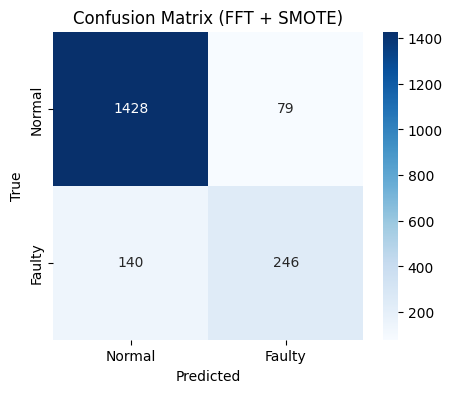

In [ ]:
from imblearn.over_sampling import SMOTE

print(" Before SMOTE:", y_train_fft.tolist().count(0), "normal,", y_train_fft.tolist().count(1), "faulty")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_fft, y_train_fft)
print(" After SMOTE:", y_train_smote.tolist().count(0), "normal,", y_train_smote.tolist().count(1), "faulty")
rf_smote = RandomForestClassifier(n_estimators=150, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test_fft)
print(" Model Performance (with FFT + SMOTE):")
print(classification_report(y_test_fft, y_pred_smote))

cm_smote = confusion_matrix(y_test_fft, y_pred_smote)
plt.figure(figsize=(5,4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Faulty'],
            yticklabels=['Normal','Faulty'])
plt.title("Confusion Matrix (FFT + SMOTE)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [21]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.7 MB/s eta 0:01:29
   ---------------------------------------- 1.0/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 1.6/150.0 MB 1.9 MB/s eta 0:01:18
    --------------------------------------- 2.4/150.0 MB 2.3 MB/s eta 0:01:05
    --------------------------------------- 3.4/150.0 MB 2.8 MB/s eta 0:00:53
   - -------------------------------------- 5.0/150.0 MB 3.5 MB/s eta 0:00:42
   - -------------------------------------- 6.8/150.0 MB 4.2 MB/s eta 0:00:34
   -- ------------------------------------- 8.9/150.0 MB 4.9 MB/s eta 0:00:29
   --- ------------------------------------ 11.3/150.0 MB 5.6 MB/s eta 0:00:25
   --- ------------------------------------ 14.2/150.0 MB 6.4 MB/s eta 0:00:2


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\manik\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


🚀 Training XGBoost...
📈 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1507
           1       0.75      0.74      0.74       386

    accuracy                           0.90      1893
   macro avg       0.84      0.84      0.84      1893
weighted avg       0.90      0.90      0.90      1893



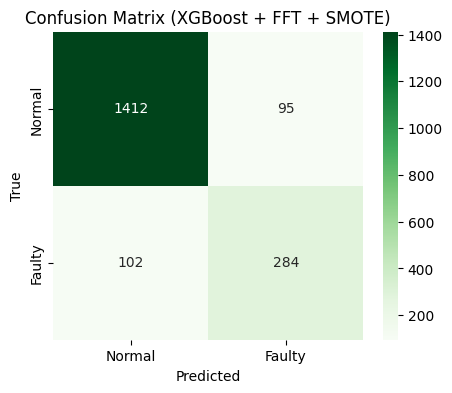

In [ ]:
from xgboost import XGBClassifier

print("Training XGBoost.")
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test_fft)
print("XGBoost Performance:")
print(classification_report(y_test_fft, y_pred_xgb))

cm_xgb = confusion_matrix(y_test_fft, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal','Faulty'], yticklabels=['Normal','Faulty'])
plt.title("Confusion Matrix (XGBoost + FFT + SMOTE)")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [ ]:
def predict_bearing_health(file_path, model, target_points=2048):
    try:
        data = np.loadtxt(file_path)  
        data_ds = resample(data, target_points, axis=0)
    except Exception as e:
        print(f"⚠️ Could not read file: {str(e)}")
        return None
    feats = extract_features_with_fft(np.expand_dims(data_ds, axis=0))  
    prediction = model.predict(feats)[0]
    label = "NORMAL" if prediction == 0 else "FAULTY"
    return label


In [ ]:
test_file = r"C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\1st_test\2003.10.22.12.06.24"

result = predict_bearing_health(test_file, xgb)  
print(f"Prediction for {test_file}: {result}")


🔍 Prediction for C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\1st_test\2003.10.22.12.06.24: NORMAL


In [ ]:
import matplotlib.pyplot as plt

def predict_folder_summary(folder_path, model, target_points=2048):
    results = []
    normal_signals = []
    faulty_signals = []

    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)

        if not os.path.isfile(file_path):
            continue

        try:
            data = np.loadtxt(file_path)
            data_ds = resample(data, target_points, axis=0)
            feats = extract_features_with_fft(np.expand_dims(data_ds, axis=0))
            prediction = model.predict(feats)[0]
            label = "NORMAL" if prediction == 0 else "FAULTY"

            results.append((file_name, label))
            if label == "NORMAL":
                normal_signals.append(data_ds)
            else:
                faulty_signals.append(data_ds)

        except Exception as e:
            print(f"⚠️ Skipping {file_name}: {e}")
    if normal_signals:
        plt.figure(figsize=(12,5))
        for signal in normal_signals:
            plt.plot(signal[:, 0], color="green", alpha=0.2)  # plotting CH1 for all
        plt.title(f"Combined NORMAL Files ({len(normal_signals)} files)")
        plt.xlabel("Sample Points")
        plt.ylabel("Amplitude (Channel 1)")
        plt.show()
    if faulty_signals:
        plt.figure(figsize=(12,5))
        for signal in faulty_signals:
            plt.plot(signal[:, 0], color="red", alpha=0.2)
        plt.title(f"Combined FAULTY Files ({len(faulty_signals)} files)")
        plt.xlabel("Sample Points")
        plt.ylabel("Amplitude (Channel 1)")
        plt.show()

    return results


C:\Users\manik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


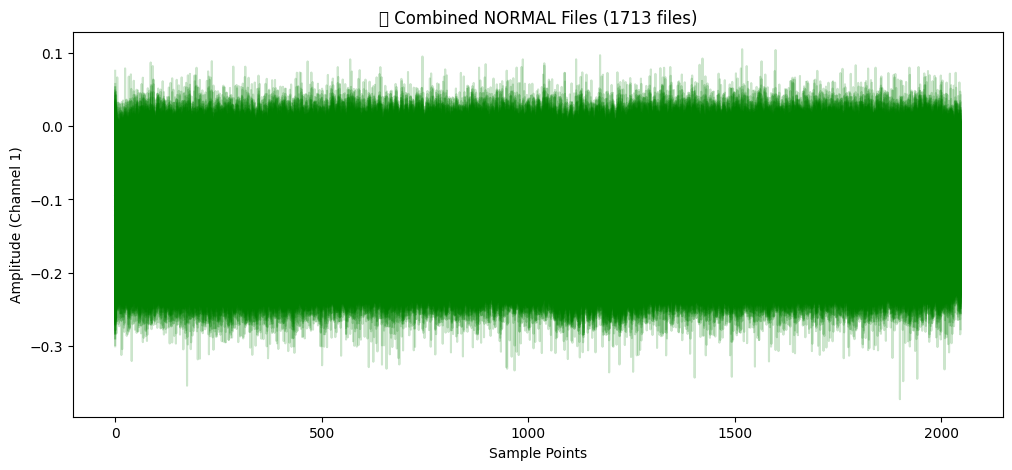

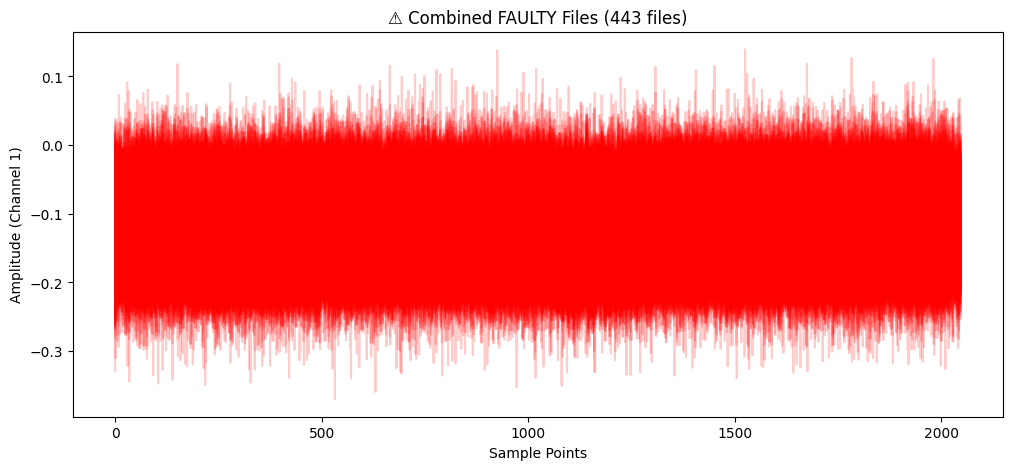

📊 Folder Predictions Summary:
2003.10.22.12.06.24: NORMAL
2003.10.22.12.09.13: NORMAL
2003.10.22.12.14.13: NORMAL
2003.10.22.12.19.13: NORMAL
2003.10.22.12.24.13: NORMAL
2003.10.22.12.29.13: NORMAL
2003.10.22.12.34.13: NORMAL
2003.10.22.12.39.13: NORMAL
2003.10.22.12.44.13: NORMAL
2003.10.22.12.49.13: NORMAL
2003.10.22.12.54.13: NORMAL
2003.10.22.12.59.13: NORMAL
2003.10.22.13.04.13: NORMAL
2003.10.22.13.09.13: NORMAL
2003.10.22.13.14.13: NORMAL
2003.10.22.13.19.13: NORMAL
2003.10.22.13.24.13: NORMAL
2003.10.22.13.29.13: NORMAL
2003.10.22.13.34.13: NORMAL
2003.10.22.13.39.13: NORMAL
2003.10.22.13.44.13: NORMAL
2003.10.22.13.49.13: NORMAL
2003.10.22.13.54.13: NORMAL
2003.10.22.13.59.13: NORMAL
2003.10.22.14.04.13: NORMAL
2003.10.22.14.09.13: NORMAL
2003.10.22.14.14.13: NORMAL
2003.10.22.14.19.13: NORMAL
2003.10.22.14.24.13: NORMAL
2003.10.22.14.29.13: NORMAL
2003.10.22.14.34.13: NORMAL
2003.10.22.14.39.13: NORMAL
2003.10.22.14.44.13: NORMAL
2003.10.22.14.49.13: NORMAL
2003.10.22.14.54.1

In [ ]:
folder_to_scan = r"C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\1st_test"

predictions = predict_folder_summary(folder_to_scan, xgb)

print(" Folder Predictions Summary:")
for fname, label in predictions:
    print(f"{fname}: {label}")


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def predict_folder_summary(folder_path, model, target_points=2048, export_csv=True, save_dir=None):
    results = []
    normal_signals = []
    faulty_signals = []

    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)

        if not os.path.isfile(file_path):
            continue

        try:
            data = np.loadtxt(file_path)
            data_ds = resample(data, target_points, axis=0)
            feats = extract_features_with_fft(np.expand_dims(data_ds, axis=0))
            prediction = model.predict(feats)[0]
            label = "NORMAL" if prediction == 0 else "FAULTY"

            results.append((file_name, label))
            if label == "NORMAL":
                normal_signals.append(data_ds)
            else:
                faulty_signals.append(data_ds)

        except Exception as e:
            print(f" Skipping {file_name}: {e}")
    total_files = len(results)
    normal_count = len(normal_signals)
    faulty_count = len(faulty_signals)

    plt.figure(figsize=(6,6))
    plt.pie([normal_count, faulty_count],
            labels=["NORMAL", "FAULTY"],
            colors=["green", "red"],
            autopct="%1.1f%%",
            startangle=90)
    plt.title(f"Prediction Distribution (Total: {total_files} files)")
    plt.show()

    if export_csv:
        df = pd.DataFrame(results, columns=["File Name", "Prediction"])
        folder_name = os.path.basename(folder_path.rstrip("\\/"))
        csv_name = f"{folder_name}_predictions.csv"
        if save_dir:
            csv_path = os.path.join(save_dir, csv_name)
        else:
            csv_path = csv_name
        df.to_csv(csv_path, index=False)
        print(f" CSV report saved as {csv_path}")

    return results



🔍 Scanning C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\1st_test...


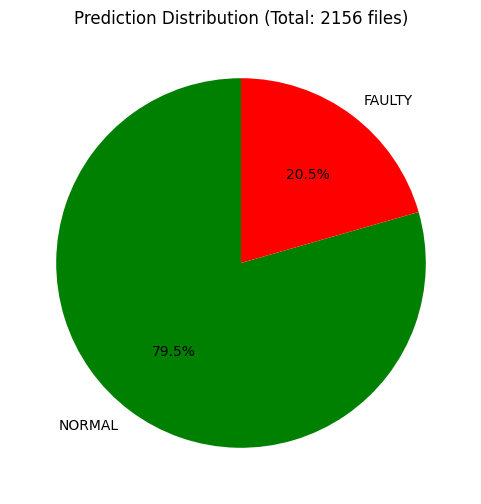

✅ CSV report saved as C:\Users\manik\OneDrive\Desktop\1st_test_predictions.csv

🔍 Scanning C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\2nd_test...


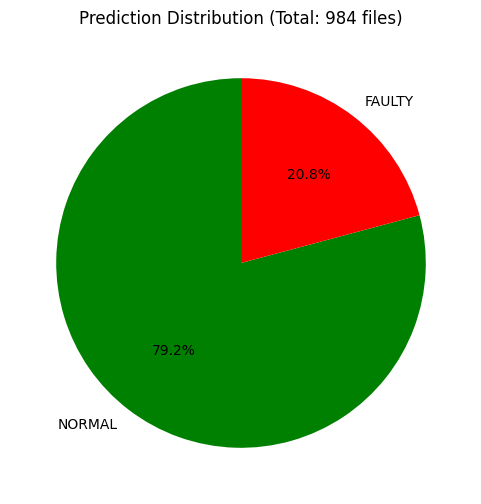

✅ CSV report saved as C:\Users\manik\OneDrive\Desktop\2nd_test_predictions.csv

🔍 Scanning C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\4th_test...


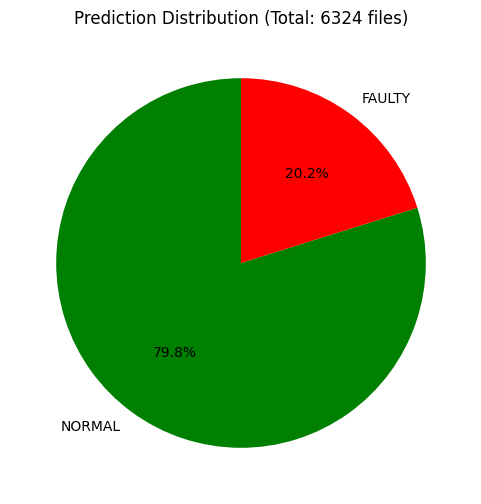

✅ CSV report saved as C:\Users\manik\OneDrive\Desktop\4th_test_predictions.csv


In [ ]:
save_to = r"C:\Users\manik\OneDrive\Desktop" 

folders = [
    r"C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\1st_test",
    r"C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\2nd_test",
    r"C:\Users\manik\OneDrive\Desktop\NASA\4.+Bearings\data\IMS\4th_test"
]

for folder in folders:
    print(f"\n🔍 Scanning {folder}...")
    predict_folder_summary(folder, xgb, save_dir=save_to)


#### Conclusion:
##### The Random Forest model achieved 94% accuracy in detecting faulty bearings using NASA IMS data. This demonstrates that statistical feature extraction from vibration signals can effectively identify early signs of failure.Future work could explore deep learning methods like CNNs or LSTMs for raw signal analysis.